<a href="https://colab.research.google.com/github/saurabhsoni1011/YoloDetectPII/blob/main/YoloPII_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!git clone 'https://github.com/AlexeyAB/darknet.git' '/content/drive/MyDrive/Colab Notebooks/PAN_CARD_DATASET/darknet'

Cloning into '/content/drive/MyDrive/Colab Notebooks/PAN_CARD_DATASET/darknet'...
remote: Enumerating objects: 15298, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 15298 (delta 1), reused 6 (delta 0), pack-reused 15289
Receiving objects: 100% (15298/15298), 13.67 MiB | 6.58 MiB/s, done.
Resolving deltas: 100% (10380/10380), done.
Checking out files: 100% (2044/2044), done.


In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/PAN_CARD_DATASET/darknet

/content/drive/MyDrive/Colab Notebooks/PAN_CARD_DATASET/darknet


In [ ]:
# change makefile to have GPU and OPENCV enabled
%cd /content/drive/MyDrive/Colab_Notebooks/PAN_CARD_DATASET/darknet
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile

In [ ]:
!make

In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/PAN_CARD_DATASET

/content/drive/MyDrive/Colab Notebooks/PAN_CARD_DATASET


In [ ]:
!python Pan_cardimages/creating-files-data-and-name.py

In [ ]:
!python Pan_cardimages/creating-train-and-test-txt-files.py

In [ ]:
!darknet/darknet

/bin/bash: darknet/darknet: Permission denied


In [ ]:
!darknet/darknet detector train Pan_cardimages/labelled_data.data darknet/cfg/yolov3_custom.cfg custom_weights/darknet53.conv.74 backup -dont_show

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import face_recognition

class YoloImageAnonymizer:
  
  #constructor
  def __init__(self,filename):
    self.filename = filename
  
  # functions blurs the area which is being blurred 
  def __blur_img(self,img, factor=1):
    kW = int(img.shape[1] / factor)
    kH = int(img.shape[0] / factor)
    # ensure the shape of the kernel is odd
    if kW % 2 == 0: kW = kW - 1
    if kH % 2 == 0: kH = kH - 1
    blurred_img = cv2.GaussianBlur(img, (kW, kH), 0)
    return blurred_img

  # function returns image with blurred face
  def __faceBlur(self,filename, face_locations):
    # load the image
    data = cv2.imread(filename)
    # get the area of face
    for result in face_locations:
      # get coordinates
      top,right,bottom,left=result
      # Mark the face area which needs to be blurred 
      detected_face=data[int(top):int(top+abs(top-bottom)),int(left):int(left+abs(left-right))]
      # Passing that marked face area to the blur function
      detected_face_blurred = self.__blur_img(detected_face, factor = 1)
      # After getting blur image of face we paste it back to our original image and then return it to our main function 
      data[int(top):int(top+abs(top-bottom)),int(left):int(left+abs(left-right))]=detected_face_blurred
    return data
  
  def YoloBlur(self):
    # load the image 
    img=cv2.imread(self.filename)
    img = cv2.resize(img, (1280, 720))
    ## provide the path for testing cofing file and tained model form colab
    net = cv2.dnn.readNetFromDarknet(r"/content/drive/MyDrive/Colab_Notebooks/PAN_CARD_DATASET/darknet/cfg/yolov3_custom_test.cfg",r"/content/drive/MyDrive/Colab_Notebooks/PAN_CARD_DATASET/backup/yolov3_custom_1000.weights")
    classes = ['dob','pan_id','person_img']
    # loading the image for face_recognition library
    image = face_recognition.load_image_file(self.filename)
    # Find all the faces in the image using the default HOG-based model.
    face_locations = face_recognition.face_locations(image)
    print("Found {} face(s) in this photograph.".format(len(face_locations)))
    # Calling the faceBlur function to detect face and obfuscate it
    image = self.__faceBlur(self.filename,face_locations)
    # We'll now use the image with blur face returned by the faceBlur further 
    img=image
    hight, width, _ = img.shape
    blob = cv2.dnn.blobFromImage(img, 1 / 255, (416, 416), (0, 0, 0), swapRB=True, crop=False)

    net.setInput(blob)

    output_layers_name = net.getUnconnectedOutLayersNames()

    layerOutputs = net.forward(output_layers_name)

    boxes = []
    confidences = []
    class_ids = []

    for output in layerOutputs:
      for detection in output:
        score = detection[5:]
        class_id = np.argmax(score)
        confidence = score[class_id]
        # Here we check that how much model is confident about is prediction 
        if confidence > 0.7:
          center_x = int(detection[0] * width)
          center_y = int(detection[1] * hight)
          w = int(detection[2] * width)
          h = int(detection[3] * hight)
          x = int(center_x - w / 2)
          y = int(center_y - h / 2)
          boxes.append([x, y, w, h])
          confidences.append((float(confidence)))
          class_ids.append(class_id)

    indexes = cv2.dnn.NMSBoxes(boxes, confidences, .5, .4)
    boxes = []
    confidences = []
    class_ids = []

    for output in layerOutputs:
      for detection in output:
        score = detection[5:]
        class_id = np.argmax(score)
        confidence = score[class_id]
        if confidence > 0.7:
          center_x = int(detection[0] * width)
          center_y = int(detection[1] * hight)
          w = int(detection[2] * width)
          h = int(detection[3] * hight)

          x = int(center_x - w / 2)
          y = int(center_y - h / 2)

          boxes.append([x, y, w, h])
          confidences.append((float(confidence)))
          class_ids.append(class_id)

    indexes = cv2.dnn.NMSBoxes(boxes, confidences, .8, .4)
    font = cv2.FONT_HERSHEY_PLAIN
    colors = np.random.uniform(0, 255, size=(len(boxes), 3))

    if len(indexes) > 0:
      for i in indexes.flatten():
        #getting co-ordinates
        x, y, w, h = boxes[i]
        # marking the co-ordinates
        detected_face = img[int(y):int(y + h), int(x):int(x + w)]
        # calling blur function to blur that region
        detected_face_blurred = self.__blur_img(detected_face, factor=1)
        # attaching blurred part in image
        img[int(y):int(y + h), int(x):int(x + w)] = detected_face_blurred
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    plt.imshow(img)
    plt.show()

Found 1 face(s) in this photograph.


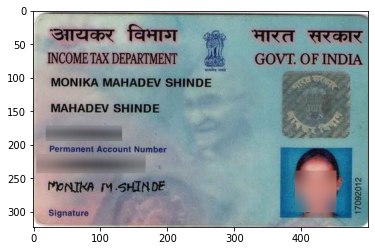

In [ ]:
obj = YoloImageAnonymizer(r"/content/drive/MyDrive/Colab_Notebooks/PAN_CARD_DATASET/Pan_cardimages/product-jpeg-500x500_2.jpeg")
obj.YoloBlur()

In [ ]:
!pip install face-recognition

     |████████████████████████████████| 100.1 MB 19 kB/s 
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566184 sha256=00c687bd85baff8b1d78ba516fdbcff6748661c1b3025285796d961261dd9db4
  Stored in directory: /root/.cache/pip/wheels/d6/81/3c/884bcd5e1c120ff548d57c2ecc9ebf3281c9a6f7c0e7e7947a
Successfully built face-recognition-models


In [ ]:
!sudo apt install tesseract-ocr
!pip install pytesseract

In [ ]:
!pip install presidio-image-redactor
!python -m spacy download en_core_web_lg

In [ ]:
!python -m pip uninstall matplotlib
!pip install matplotlib==3.1.3

In [ ]:
from matplotlib import pyplot
from matplotlib.patches import Rectangle
import face_recognition
import cv2
from PIL import Image
from presidio_image_redactor import ImageRedactorEngine 
import numpy as np

class ImageAnonymizerWithDlib:
  #constructor
  def __init__(self,filename):
    self.filename = filename

  
  def AnonymizeImageDlib(self):
    image = face_recognition.load_image_file(self.filename)
    img = cv2.imread(self.filename)
    # Find all the faces in the image using the default HOG-based model.
    face_locations = face_recognition.face_locations(image)
    print("Found {} face(s) in this photograph.".format(len(face_locations)))
    image = self.draw_image_with_boxes(self.filename,face_locations)
    self.__anonymize_image(image)   
  
  #function to blur image
  def __blur_img(self,image, factor = 1):
    kW = int(image.shape[1] / factor)
    kH = int(image.shape[0] / factor)
    #ensure the shape of the kernel is odd
    if kW % 2 == 0: kW = kW - 1
    if kH % 2 == 0: kH = kH - 1
    blurred_img = cv2.GaussianBlur(image, (kW, kH), 0)
    return blurred_img

  # draw an image with detected objects
  def draw_image_with_boxes(self,filename, face_locations):
    # load the image
    data = cv2.imread(filename)
    # plot each box
    for result in face_locations:
      # get coordinates
      top,right,bottom,left=result
      # create the shape
      #rect = Rectangle((left, top), abs(left-right), abs(top-bottom), fill=False, color='red')
      detected_face=data[int(top):int(top+abs(top-bottom)),int(left):int(left+abs(left-right))]
      detected_face_blurred = self.__blur_img(detected_face, factor = 1)
      data[int(top):int(top+abs(top-bottom)),int(left):int(left+abs(left-right))]=detected_face_blurred
      # draw the box
      #ax.add_patch(rect)
      # show the plot
    return data
  def __anonymize_image(self,image):
    color_coverted = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    #this is used to read image using PIL
    image=Image.fromarray(color_coverted)
    engine = ImageRedactorEngine()
    # Redact the image with pink color
    redacted_image = engine.redact(image, (255, 192, 203))   
    #display image
    pyplot.imshow(np.asarray(redacted_image))

In [ ]:
obj1 = ImageAnonymizerWithDlib(img)
obj1.AnonymizeImageDlib() 

In [ ]:
!pip install mtcnn

In [ ]:
from matplotlib import pyplot
from matplotlib.patches import Rectangle
from mtcnn.mtcnn import MTCNN
import cv2
from PIL import Image
from presidio_image_redactor import ImageRedactorEngine 
import numpy as np

class ImageAnonymizer:
   #constructor
   def __init__(self,filename):
     self.filename = filename

   def AnonymizeImage(self): 
     image = cv2.imread(self.filename)
     detector = MTCNN()
     faces = detector.detect_faces(image)
     image = self.__ano_face(self.filename, faces)
     self.__anonymize_image(image)
   
   #function to blur image
   def __blur_img(self,image, factor = 1):
     kW = int(image.shape[1] / factor)
     kH = int(image.shape[0] / factor)
     #ensure the shape of the kernel is odd
     if kW % 2 == 0: kW = kW - 1
     if kH % 2 == 0: kH = kH - 1
     blurred_img = cv2.GaussianBlur(image, (kW, kH), 0)
     return blurred_img
    
   def __ano_face(self,filename,result_list):
     #load image
     image = cv2.imread(filename)
     #feteching face co-ordinates and sending it to blur function
     for result in result_list:
       #getting co-ordinates of image
       x,y,w,h = result['box']
       #marking above co-ordinates in image
       detected_face = image[int(y):int(y+h), int(x):int(x+w)]
       #calling blur function to blur that region
       detected_face_blurred = self.__blur_img(detected_face, factor = 1)
       #attaching blurred part in image 
       image[int(y):int(y+h), int(x):int(x+w)] = detected_face_blurred
     return image
   
   def __anonymize_image(self,image):
     color_coverted = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
     #this is used to read image using PIL
     image=Image.fromarray(color_coverted)
     engine = ImageRedactorEngine()
     # Redact the image with pink color
     redacted_image = engine.redact(image, (255, 192, 203))   
     #display image
     pyplot.imshow(np.asarray(redacted_image))

In [ ]:
obj1 = ImageAnonymizer(img)
obj1.AnonymizeImage()